In [2]:
import pandas as pd
import numpy as np
import seaborn
import time
from prefixspan import prefix_span
from data_loader import importDatabase
import matplotlib.pyplot as plt
import random

In [3]:
#database paths
bible = "dataSets/BIBLE.txt"
leviathan = "dataSets/LEVIATHAN.txt"
korsak = "dataSets/kosarak10k.txt"

In [27]:
# speed vs supp theshold %
test_support_thresholds = np.linspace(0.01, 0.05, 7)
database_paths = [bible, leviathan, korsak]
databases = [random.sample(importDatabase(path), 5000) for path in database_paths]
names = ["Bible", "Leviathan", "Korsak"]

execution_times = []
supp_thresholds = []
algorithm = []
database_name = []

for sth in test_support_thresholds:
    for db, db_name in zip(databases, names):
        # calculate actual support value
        sup = int(sth*len(db))

        print(f"Database: {db_name}, Supp%: {sth}, supp value: {sup}")

        # time datamining 
        start_time = time.time()
        prefix_span(sup, db)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(sth)
        algorithm.append("prefix_span")
        database_name.append(db_name)

time_vs_sup = pd.DataFrame({"execution time [s]": execution_times, 
                            "support threshold [%]": supp_thresholds, 
                            "algorithm": algorithm,
                            "database": database_name})


Database: Bible, Supp%: 0.01, supp value: 50
Database: Leviathan, Supp%: 0.01, supp value: 50
Database: Korsak, Supp%: 0.01, supp value: 50
Database: Bible, Supp%: 0.016666666666666666, supp value: 83
Database: Leviathan, Supp%: 0.016666666666666666, supp value: 83
Database: Korsak, Supp%: 0.016666666666666666, supp value: 83
Database: Bible, Supp%: 0.023333333333333334, supp value: 116
Database: Leviathan, Supp%: 0.023333333333333334, supp value: 116
Database: Korsak, Supp%: 0.023333333333333334, supp value: 116
Database: Bible, Supp%: 0.03, supp value: 150
Database: Leviathan, Supp%: 0.03, supp value: 150
Database: Korsak, Supp%: 0.03, supp value: 150
Database: Bible, Supp%: 0.03666666666666667, supp value: 183
Database: Leviathan, Supp%: 0.03666666666666667, supp value: 183
Database: Korsak, Supp%: 0.03666666666666667, supp value: 183
Database: Bible, Supp%: 0.043333333333333335, supp value: 216
Database: Leviathan, Supp%: 0.043333333333333335, supp value: 216
Database: Korsak, Supp

Text(0.5, 1.0, 'execution time vs support theshold for databases with fixed size of 5000 sequences')

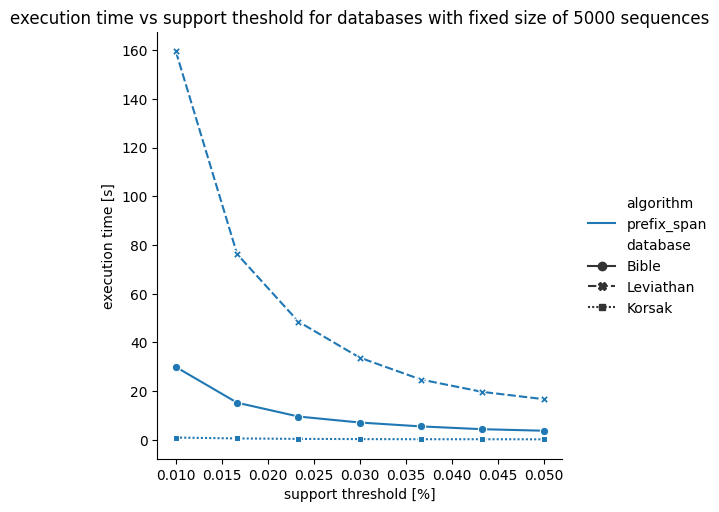

In [30]:
# plot results 
seaborn.relplot(data=time_vs_sup, 
                 x="support threshold [%]",
                 y="execution time [s]", 
                 hue="algorithm",
                 style="database",
                 kind="line",
                 markers=True
                )
plt.title("execution time vs support theshold for databases with fixed size of 5000 sequences")


In [10]:
# speed vs n of sequences
database_paths = [bible]
databases = [importDatabase(path) for path in database_paths]
names = ["Bible"]
size_test_support_threshold = int(0.05 * 5000)

maxSize = min([len(db) for db in databases])
db_sizes = np.linspace(100, maxSize, 10)

execution_times = []
database_size = []
algorithm = []
supp_thresholds = []
database_name = []


for db, db_name in zip(databases, names):
    for size in db_sizes:
        print(f"Database: {db_name}, db size: {size}")

        # sample from database to create smalled database
        db_sampled = random.sample(db, int(size))

        # time datamining 
        start_time = time.time()
        prefix_span(size_test_support_threshold, db_sampled)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(size_test_support_threshold)
        algorithm.append("prefix_span")
        database_name.append(db_name)
        database_size.append(int(size))

time_vs_size = pd.DataFrame({"execution time [s]": execution_times, 
                            "support threshold [%]": supp_thresholds, 
                            "algorithm": algorithm,
                            "database": database_name,
                            "N of sequences": database_size})


Database: Bible, db size: 100.0
Database: Bible, db size: 4129.888888888889
Database: Bible, db size: 8159.777777777777
Database: Bible, db size: 12189.666666666666
Database: Bible, db size: 16219.555555555555
Database: Bible, db size: 20249.444444444445
Database: Bible, db size: 24279.333333333332
Database: Bible, db size: 28309.22222222222
Database: Bible, db size: 32339.11111111111
Database: Bible, db size: 36369.0


Text(0.5, 1.0, 'Dabase size vs execution time for Bible with minsupp=0.05 of 5000')

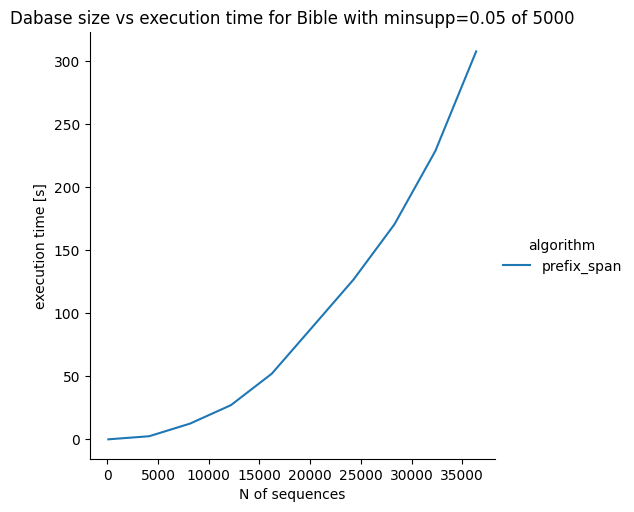

In [14]:
# plot results 
seaborn.relplot(data=time_vs_size, 
                 x="N of sequences",
                 y="execution time [s]", 
                 hue="algorithm",
                 #col="database",
                 kind="line",
                 markers=True
                )
plt.title("Dabase size vs execution time for Bible with minsupp=0.05 of 5000")